<a href="https://colab.research.google.com/github/moharamfatema/face-recognition-pca/blob/main/faces_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition 
## PCA

## Mount Drive and download data

In [ ]:
# ! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd
%ls

drive/  sample_data/


In [ ]:
# ! mkdir ~/.kaggle drive/MyDrive/faces
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets download -d kasikrit/att-database-of-faces -p drive/MyDrive/faces
# ! mkdir drive/MyDrive/faces/images
# ! unzip drive/MyDrive/faces/att-database-of-faces.zip -d drive/MyDrive/faces/images

In [ ]:
# %mkdir drive/MyDrive/faces/out/projections

## Imports

In [ ]:
import pandas as pd
import zipfile
import os
import numpy as np
import cv2
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

## Constants

In [ ]:
IN_DIR = "drive/MyDrive/faces/images"
OUT_DIR = "drive/MyDrive/faces/out"

## Read and split

In [ ]:
data = np.zeros((400,10304))
label = np.zeros((400,1))

In [ ]:
i = 0
for dir in os.listdir(IN_DIR):
  if dir == '.ipynb_checkpoints' or dir == "README":
    continue
  folderPath = os.path.join(IN_DIR,dir)
  # loops 10 times here for each subject
  for individualImage in os.listdir(folderPath):
    # individualImage is 1.pgm for ex
    # imPath is the image path of individualImage
    imPath = os.path.join(folderPath,individualImage)
    image = cv2.imread(imPath,cv2.IMREAD_GRAYSCALE)
    data[i,:] = image.flatten()
    label[i] =  int(dir[1:])
    i+=1

In [ ]:
data_train = np.zeros((200,10304))
label_train = np.zeros((200,1))
data_test = np.zeros((200,10304))
label_test = np.zeros((200,1))
i = 0
k = 0
for j in range(0,400):
  if j%2 == 0:
    data_test[i,:] = data[j,:]
    label_test[i] = label[j]
    i+=1
  else:
    data_train[k,:] = data[j,:]
    label_train[k] = label[j]
    k+=1

## Calculate projection matrix

In [ ]:
from numpy.linalg import eigh

def get_pca(
    X : np.ndarray,
    alpha = None,
    r = None
) -> tuple:
  '''
  Performs principal component analysis for a data matrix X

  Returns

  P : np.ndarray
    projection matrix

  mean : np.ndarray
    mean vector
  '''
  mean = np.mean(X, axis=0,keepdims=True)
  z = X - mean
  w, V = eigh(np.cov(z.T))

  indices = np.argsort(w)[::-1]
  w = w[indices]
  V = V[:,indices]

  if r is None:
    # fraction of variance for every component
    
    variance_explained = [w[i] / w.sum() for i in range(len(w))]

    cumulative_variance_explained = np.cumsum(variance_explained)

    if type(alpha) == int:
      info = cumulative_variance_explained >= alpha
      for i,v in enumerate(info):
        if v:
          r = i + 1
          break
    elif alpha is not None:
      r = []
      for a in alpha:
        info = cumulative_variance_explained >= a
        for i,v in enumerate(info):
          if v:
            r_a = i + 1
            break
        r.append(r_a)

  print(f"at alpha = {alpha}, r = {r}")
  if type(r) == int:
    P = V[:,:r]
  else:
    P = []
    for i in r:
      P.append(V[:,:i])

  return (P, mean)

In [ ]:
alphas = np.array([0.8,0.85,0.9,0.95])

# projection_matrices , _ = get_pca(data_train,alpha=alphas)

## save projection matrices

In [ ]:
# for i,p in enumerate(projection_matrices):
#   p = np.array(p)
#   np.save(f"{OUT_DIR}/projections/p_{alphas[i]}",p)

## Load saved projection matrices

In [ ]:
projection_matrices = []
for i,a in enumerate(alphas):
  p = np.load(f"{OUT_DIR}/projections/p_{a}.npy")
  projection_matrices.append(p)

## Project train and test

In [ ]:
x_pca_train = []
x_pca_test = []

for i, p in enumerate(projection_matrices):
  x_pca_train.append(data_train.dot(p))
  x_pca_test.append(data_test.dot(p))
  print(f"train: {x_pca_train[i].shape}")
  print(f"test: {x_pca_test[i].shape}")

train: (200, 36)
test: (200, 36)
train: (200, 52)
test: (200, 52)
train: (200, 76)
test: (200, 76)
train: (200, 117)
test: (200, 117)


## KNN classifier

In [ ]:
def classify(n):
  accuracy = []
  for i, x_train in enumerate(x_pca_train):
    clf = KNeighborsClassifier(n)
    clf.fit(x_train,label_train.ravel())
    y_pred = clf.predict(x_pca_test[i])
    del clf
    acc = sk.metrics.accuracy_score(label_test,y_pred)
    accuracy.append(acc)

  return accuracy

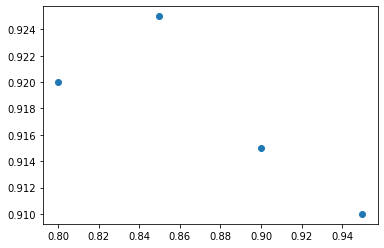

In [ ]:
accuracy = classify(1)
plt.scatter(alphas, accuracy)
plt.show()

## Analysis

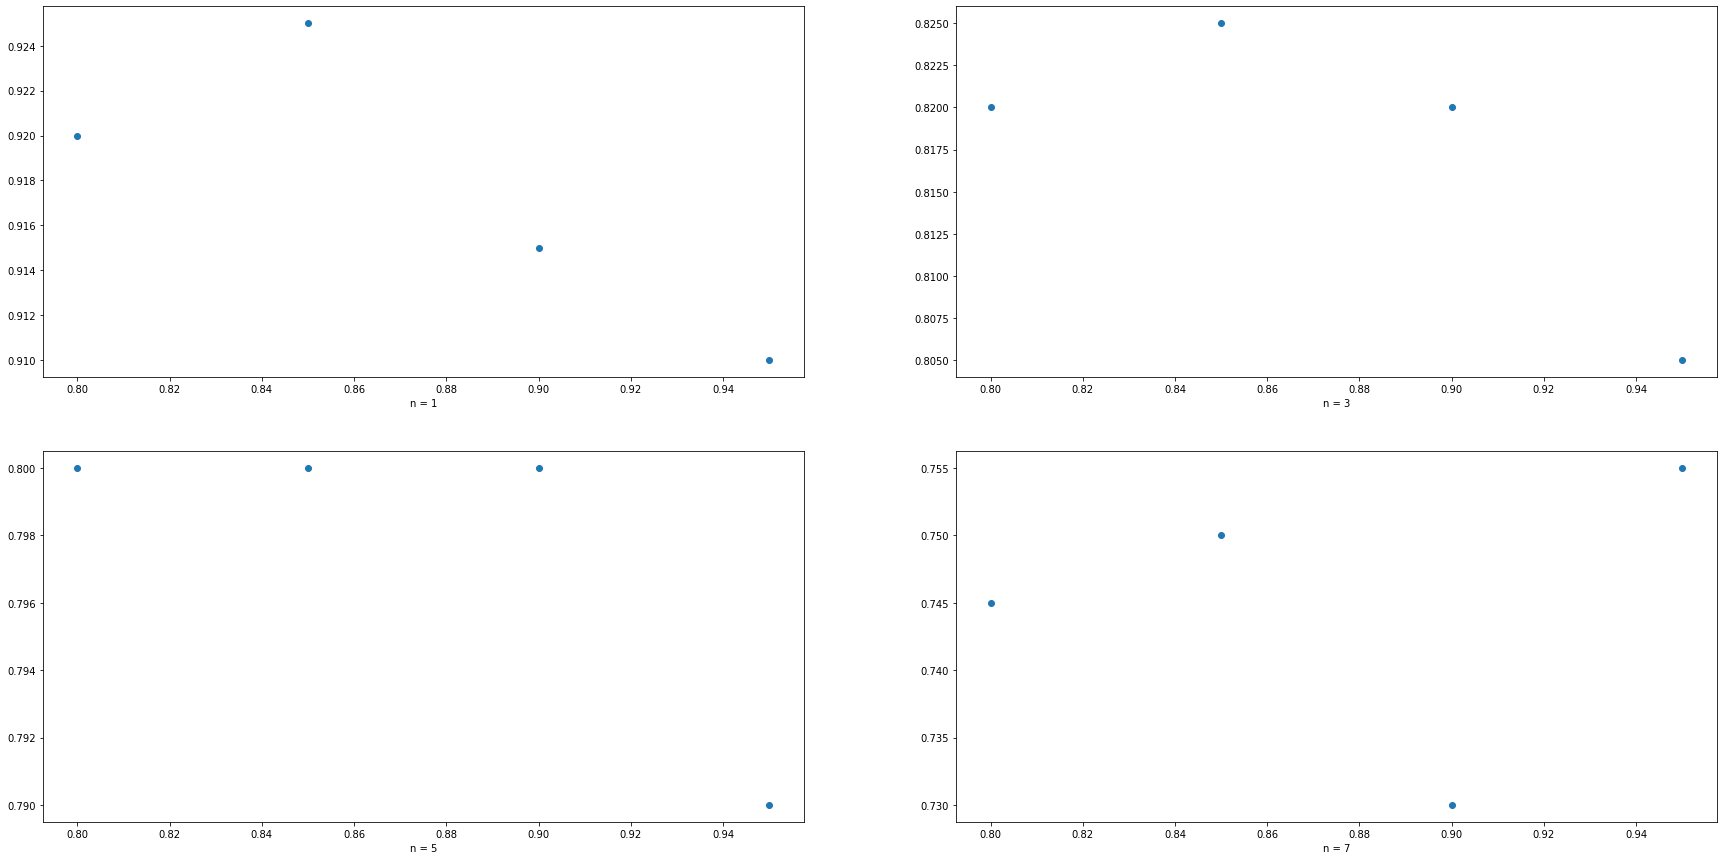

In [ ]:
n = [1,3,5,7]
accuracies = []
fig, axes = plt.subplots(2,2,figsize=(30,15))

for i,v in enumerate(n):
  accuracies.append(classify(v))
  axes[int(i/2)][i%2].scatter(alphas,accuracies[i])
  axes[int(i/2)][i%2].set_xlabel(f"n = {v}")


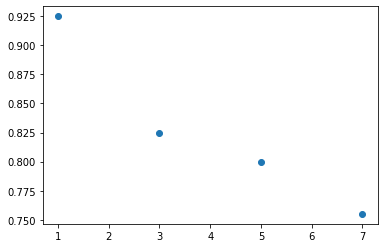

In [ ]:
max_accuracies = [max(a) for a in accuracies]
plt.scatter(n,max_accuracies)